In [1]:
# [STAR] All the Imports

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from pathlib import Path
import ast
import pandas as pd
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import re
import cv2

In [7]:
# [OLD] Code for classification

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/media/yu-hao/WindowsData/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_ft)

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [2]:
# [STAR] All the functions for reading the data for Wheat Dataset

from scipy import ndimage

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    r1 = [float(x) for x in r]
    r = r1
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df = pd.read_csv('/media/yu-hao/WindowsData/WheatDataset/train.csv')
train_df.shape

train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

temp = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
#train_df[['x', 'y', 'w', 'h']] = 
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = temp[:, 0]#train_df['x'].astype(np.float)
train_df['y'] = temp[:, 1]#train_df['y'].astype(np.float)
train_df['w'] = temp[:, 2]#train_df['w'].astype(np.float)
train_df['h'] = temp[:, 3]#train_df['h'].astype(np.float)

# df['bbox'] = df['bbox'].apply(lambda x: np.array(x))
# x = np.array(list(df['bbox']))
# print(x)
# for i, dim in enumerate(['x', 'y', 'w', 'h']):
#     df[dim] = x[:, i]

# # df.drop('bbox', axis=1, inplace=True)
# #df.head()

class WheatDatasetOld(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, transforms = None):
        super().__init__()
        
        self.df = df
        self.image_ids  = self.df['image_id'].unique()
        self.image_dir  = Path(image_dir)
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records  = self.df[self.df['image_id'] == image_id]
        
        im_name = image_id + '.jpg'
        img = Image.open(self.image_dir/im_name).convert("RGB")
        img = T.ToTensor()(img)
        
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        #print('boxes shape is ',boxes.shape)
        boxes = torch.Tensor(boxes).to(device)#, device='cuda:0')#dtype=torch.int64)
        
        labels = torch.ones((records.shape[0], ), dtype=torch.int64)
        
        target = {}
        target['boxes']  = boxes
        target['labels'] = labels
        target['image_id']  = torch.tensor([idx])
        
        return img, target, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

class DBTDataset(torch.utils.data.Dataset):
    def __init__(self, train_set = 1, transforms = None):
        super().__init__()
        
        if train_set == 1:
            self.train_start  = 0
            self.train_end    = 150
        else:
            self.train_start  = 150
            self.train_end    = 200
        
        self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
        self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy.npy')[self.train_start:self.train_end]
        self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx.npy')[self.train_start:self.train_end]
        self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy.npy')[self.train_start:self.train_end]
        self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr.npy')[self.train_start:self.train_end]
        self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr.npy')[self.train_start:self.train_end]
        
        self.transforms = transforms
    
    def __getitem__(self, idx):
        img = self.trainx[idx, 0].astype('float32')/60000.0
        img[img > 1] = 1
        img = ndimage.interpolation.zoom(img, 0.25)
        
        img = np.expand_dims(img, 0)
        img = np.concatenate([img, img, img], axis=0)
        
        #print(img.shape, 'img shape is')
        #img = torch.Tensor(img).to(device)
        #img = T.ToTensor()(img).to(device)
        
        boxes = np.array([self.coordx[idx]/4, self.coordy[idx]/4, self.width_arr[idx]/4, self.height_arr[idx]/4])#records[['x', 'y', 'w', 'h']].values
        #print(boxes)
        boxes = np.expand_dims(boxes, axis=0)
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        #boxes = boxes
        #print('boxes shape is ',boxes.shape)
        #boxes = torch.Tensor(boxes).to(device)#, device='cuda:0')#dtype=torch.int64)
        
        #labels = torch.ones((1,), dtype=torch.int64)#torch.Tensor(self.trainy[idx]).to(device)
        
        area = self.width_arr[idx] * self.height_arr[idx]
        area = torch.Tensor(area)#.to(device)

        # there is only one class
        labels =  torch.ones((1,)).type(torch.int64)#.to(device)#torch.Tensor(np.array([1])).type(torch.int64).to(device)
        
        # suppose all instances are not crowd
        iscrowd = torch.Tensor(np.array([0])).type(torch.int64)#.to(device)
        
        target = {}
        target['boxes']     = torch.Tensor(boxes)
        target['labels']    = labels
        target['image_id']  = torch.tensor([idx])
        target['area']      = area
        target['iscrowd']   = iscrowd
        
        return img, target, idx
    
    def __len__(self):
        return self.trainx.shape[0]

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
# [STAR] Wheat Dataset and Model Creation

image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

print(valid_df.shape, train_df.shape)

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

def collate_fn(batch):
    return tuple(zip(*batch))

DIR_INPUT = '/media/yu-hao/WindowsData/WheatDataset'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST  = f'{DIR_INPUT}/test'

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

In [3]:
# [STAR] DBT Dataset and Model Creation

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset     = DBTDataset(train_set=1)
valid_dataset     = DBTDataset(train_set=0)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=1, collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1, collate_fn=collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
params       = [p for p in model.parameters() if p.requires_grad]
optimizer    = torch.optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=0.0001)
lr_scheduler = None

In [12]:
# [STAR] Training loop for DBT dataset
#params       = [p for p in model.parameters() if p.requires_grad]
#optimizer    = torch.optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=0.0001)

loss_hist     = Averager()
val_loss_hist = Averager()


num_epochs = 2000
for epoch in range(num_epochs):
    loss_hist.reset()
    loss_hist.reset()
    
    model.train()
    itr = 1
    for images, targets, image_ids in train_data_loader:
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))
        
        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses     = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    with torch.no_grad():
        for images, targets, image_ids in valid_data_loader:
            new_images  = []
            for img in images:
                new_images.append(torch.Tensor(img).to(device))

            images    = new_images
            targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            #print(loss_dict)

            losses     = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            val_loss_hist.send(loss_value)

            if itr % 50 == 0:
                print(f"Validation Iteration #{itr} loss: {loss_value}")
            itr = itr+1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} Train loss: {loss_hist.value}")
    print(f"Epoch #{epoch} Val   loss: {val_loss_hist.value}")
    
    torch.save(model.state_dict(), 'fasterrcnn_resnet50_dbt2.pth')

Validation Iteration #50 loss: 0.4085538983345032
Epoch #0 Train loss: 0.636813370020766
Epoch #0 Val   loss: 0.44265748216555667
Validation Iteration #50 loss: 0.2827727794647217
Epoch #1 Train loss: 0.3782736674735421
Epoch #1 Val   loss: 0.3844927709836226
Validation Iteration #50 loss: 0.24969077110290527
Epoch #2 Train loss: 0.3050282656362182
Epoch #2 Val   loss: 0.35385303084666914
Validation Iteration #50 loss: 0.23800887167453766
Epoch #3 Train loss: 0.27857378870248795
Epoch #3 Val   loss: 0.33550997279011285
Validation Iteration #50 loss: 0.23004253208637238
Epoch #4 Train loss: 0.2650080503601777
Epoch #4 Val   loss: 0.32332662573227516
Validation Iteration #50 loss: 0.21421855688095093
Epoch #5 Train loss: 0.25437537659155696
Epoch #5 Val   loss: 0.31280608819081235
Validation Iteration #50 loss: 0.19781391322612762
Epoch #6 Train loss: 0.24924509815479579
Epoch #6 Val   loss: 0.30464147178681344
Validation Iteration #50 loss: 0.20302604138851166
Epoch #7 Train loss: 0.242

Epoch #61 Train loss: 0.2196163386106491
Epoch #61 Val   loss: 0.24146022756697227
Validation Iteration #50 loss: 0.2291772961616516
Epoch #62 Train loss: 0.22310244448875127
Epoch #62 Val   loss: 0.24132444157341315
Validation Iteration #50 loss: 0.22860245406627655
Epoch #63 Train loss: 0.22328561779699826
Epoch #63 Val   loss: 0.2411917495684555
Validation Iteration #50 loss: 0.22194786369800568
Epoch #64 Train loss: 0.22309334929052152
Epoch #64 Val   loss: 0.2410555232382385
Validation Iteration #50 loss: 0.21912020444869995
Epoch #65 Train loss: 0.22530981231676905
Epoch #65 Val   loss: 0.2409363484709135
Validation Iteration #50 loss: 0.2235022634267807
Epoch #66 Train loss: 0.22318214687861895
Epoch #66 Val   loss: 0.2407721482414055
Validation Iteration #50 loss: 0.22217078506946564
Epoch #67 Train loss: 0.21994693694930328
Epoch #67 Val   loss: 0.24066066575063838
Validation Iteration #50 loss: 0.22713570296764374
Epoch #68 Train loss: 0.22115268871972435
Epoch #68 Val   loss

Epoch #122 Train loss: 0.22778350193249552
Epoch #122 Val   loss: 0.2398919446290173
Validation Iteration #50 loss: 0.2212560921907425
Epoch #123 Train loss: 0.22808528299394407
Epoch #123 Val   loss: 0.23989919952992766
Validation Iteration #50 loss: 0.219659224152565
Epoch #124 Train loss: 0.22791755081791626
Epoch #124 Val   loss: 0.23990420662439788
Validation Iteration #50 loss: 0.2207489013671875
Epoch #125 Train loss: 0.22848699045808693
Epoch #125 Val   loss: 0.2399053082452298
Validation Iteration #50 loss: 0.21881623566150665
Epoch #126 Train loss: 0.22659223173793994
Epoch #126 Val   loss: 0.23991879426407714
Validation Iteration #50 loss: 0.22093413770198822
Epoch #127 Train loss: 0.228463183108129
Epoch #127 Val   loss: 0.2399243435356766
Validation Iteration #50 loss: 0.2199174463748932
Epoch #128 Train loss: 0.22893632634689934
Epoch #128 Val   loss: 0.23994013748854204
Validation Iteration #50 loss: 0.22183161973953247
Epoch #129 Train loss: 0.2274404987692833
Epoch #12

Validation Iteration #50 loss: 0.2386174201965332
Epoch #183 Train loss: 0.21431085643799683
Epoch #183 Val   loss: 0.24057053038881573
Validation Iteration #50 loss: 0.23742817342281342
Epoch #184 Train loss: 0.21453114206853666
Epoch #184 Val   loss: 0.2405720954315578
Validation Iteration #50 loss: 0.23707926273345947
Epoch #185 Train loss: 0.21502011622253217
Epoch #185 Val   loss: 0.24057247290638875
Validation Iteration #50 loss: 0.24295388162136078
Epoch #186 Train loss: 0.21444671640270635
Epoch #186 Val   loss: 0.24056553899481775
Validation Iteration #50 loss: 0.23907342553138733
Epoch #187 Train loss: 0.2133789360523224
Epoch #187 Val   loss: 0.2405639162040186
Validation Iteration #50 loss: 0.2381870597600937
Epoch #188 Train loss: 0.213935130128735
Epoch #188 Val   loss: 0.24055931903649308
Validation Iteration #50 loss: 0.23840107023715973
Epoch #189 Train loss: 0.2125599733308742
Epoch #189 Val   loss: 0.24055536901540603
Validation Iteration #50 loss: 0.2380447834730148

Epoch #243 Train loss: 0.20299391722992846
Epoch #243 Val   loss: 0.23988062584911288
Validation Iteration #50 loss: 0.2409779280424118
Epoch #244 Train loss: 0.20327961189966454
Epoch #244 Val   loss: 0.23985448878264315
Validation Iteration #50 loss: 0.24394544959068298
Epoch #245 Train loss: 0.2021455407926911
Epoch #245 Val   loss: 0.23982374570923645
Validation Iteration #50 loss: 0.23652292788028717
Epoch #246 Train loss: 0.20114816842894806
Epoch #246 Val   loss: 0.2397881960922667
Validation Iteration #50 loss: 0.2404906153678894
Epoch #247 Train loss: 0.2017893685322059
Epoch #247 Val   loss: 0.23974820127521201
Validation Iteration #50 loss: 0.24176645278930664
Epoch #248 Train loss: 0.1995934036217238
Epoch #248 Val   loss: 0.2397141982448812
Validation Iteration #50 loss: 0.24132059514522552
Epoch #249 Train loss: 0.20007660043867012
Epoch #249 Val   loss: 0.2396765936429684
Validation Iteration #50 loss: 0.2402980625629425
Epoch #250 Train loss: 0.19951288951070686
Epoch #

Validation Iteration #50 loss: 0.22076554596424103
Epoch #304 Train loss: 0.18208581405250648
Epoch #304 Val   loss: 0.23645762349061977
Validation Iteration #50 loss: 0.22077609598636627
Epoch #305 Train loss: 0.18263771463381617
Epoch #305 Val   loss: 0.23639046843924555
Validation Iteration #50 loss: 0.22234946489334106
Epoch #306 Train loss: 0.18097372705999173
Epoch #306 Val   loss: 0.2363232484708541
Validation Iteration #50 loss: 0.22088199853897095
Epoch #307 Train loss: 0.180458034339704
Epoch #307 Val   loss: 0.23625340367054248
Validation Iteration #50 loss: 0.2210901379585266
Epoch #308 Train loss: 0.1802751672895331
Epoch #308 Val   loss: 0.23618606086806454
Validation Iteration #50 loss: 0.22044488787651062
Epoch #309 Train loss: 0.1808671798360975
Epoch #309 Val   loss: 0.23611743048979686
Validation Iteration #50 loss: 0.22390691936016083
Epoch #310 Train loss: 0.1802146426941219
Epoch #310 Val   loss: 0.23605483895314675
Validation Iteration #50 loss: 0.224527850747108

Epoch #364 Train loss: 0.1580626533219689
Epoch #364 Val   loss: 0.23252749040455914
Validation Iteration #50 loss: 0.24790075421333313
Epoch #365 Train loss: 0.15781829408124873
Epoch #365 Val   loss: 0.23246610668237694
Validation Iteration #50 loss: 0.25726598501205444
Epoch #366 Train loss: 0.1566423526719997
Epoch #366 Val   loss: 0.23241084478006901
Validation Iteration #50 loss: 0.25585150718688965
Epoch #367 Train loss: 0.1548733356359758
Epoch #367 Val   loss: 0.23235503080796238
Validation Iteration #50 loss: 0.25032633543014526
Epoch #368 Train loss: 0.15480172614517965
Epoch #368 Val   loss: 0.23229794744118715
Validation Iteration #50 loss: 0.24960002303123474
Epoch #369 Train loss: 0.1533893270320014
Epoch #369 Val   loss: 0.2322397361797999
Validation Iteration #50 loss: 0.2548479437828064
Epoch #370 Train loss: 0.1531638426608161
Epoch #370 Val   loss: 0.23218070202328076
Validation Iteration #50 loss: 0.24954955279827118
Epoch #371 Train loss: 0.15281496157771662
Epoch

Validation Iteration #50 loss: 0.2178821563720703
Epoch #425 Train loss: 0.13633841825158974
Epoch #425 Val   loss: 0.22880996851692478
Validation Iteration #50 loss: 0.21651208400726318
Epoch #426 Train loss: 0.13675992975109502
Epoch #426 Val   loss: 0.22874220775937287
Validation Iteration #50 loss: 0.21742652356624603
Epoch #427 Train loss: 0.13576965524177803
Epoch #427 Val   loss: 0.22867336178815767
Validation Iteration #50 loss: 0.2162363976240158
Epoch #428 Train loss: 0.13605046487952532
Epoch #428 Val   loss: 0.2286032411051583
Validation Iteration #50 loss: 0.2167111486196518
Epoch #429 Train loss: 0.13469764805938067
Epoch #429 Val   loss: 0.22853457700054633
Validation Iteration #50 loss: 0.21609055995941162
Epoch #430 Train loss: 0.1341715568774625
Epoch #430 Val   loss: 0.22846370074029013
Validation Iteration #50 loss: 0.21826007962226868
Epoch #431 Train loss: 0.13373056367823952
Epoch #431 Val   loss: 0.22839211859339661
Validation Iteration #50 loss: 0.2152994722127

Epoch #485 Train loss: 0.11640330796179019
Epoch #485 Val   loss: 0.224604209172137
Validation Iteration #50 loss: 0.21629686653614044
Epoch #486 Train loss: 0.11698296097548384
Epoch #486 Val   loss: 0.22454768347831497
Validation Iteration #50 loss: 0.21965950727462769
Epoch #487 Train loss: 0.11607071522035096
Epoch #487 Val   loss: 0.2244878957672855
Validation Iteration #50 loss: 0.2213863581418991
Epoch #488 Train loss: 0.11636122355335637
Epoch #488 Val   loss: 0.22443119532374328
Validation Iteration #50 loss: 0.21995557844638824
Epoch #489 Train loss: 0.11556214388263852
Epoch #489 Val   loss: 0.22437058287311573
Validation Iteration #50 loss: 0.21972814202308655
Epoch #490 Train loss: 0.11530627349489614
Epoch #490 Val   loss: 0.2243146781936421
Validation Iteration #50 loss: 0.21821606159210205
Epoch #491 Train loss: 0.11604370235612518
Epoch #491 Val   loss: 0.22425870560901734
Validation Iteration #50 loss: 0.21634991466999054
Epoch #492 Train loss: 0.11500451047169535
Epo

Validation Iteration #50 loss: 0.24021892249584198
Epoch #546 Train loss: 0.10225194653398112
Epoch #546 Val   loss: 0.221920099016685
Validation Iteration #50 loss: 0.2404460906982422
Epoch #547 Train loss: 0.10229636964045073
Epoch #547 Val   loss: 0.221888038987092
Validation Iteration #50 loss: 0.24217213690280914
Epoch #548 Train loss: 0.10213144025520275
Epoch #548 Val   loss: 0.22185636893138175
Validation Iteration #50 loss: 0.23481112718582153
Epoch #549 Train loss: 0.10266457066724174
Epoch #549 Val   loss: 0.22182468076060702
Validation Iteration #50 loss: 0.23692883551120758
Epoch #550 Train loss: 0.10205559177618277
Epoch #550 Val   loss: 0.2217920644688037
Validation Iteration #50 loss: 0.23185712099075317
Epoch #551 Train loss: 0.10234420119147551
Epoch #551 Val   loss: 0.22175644401672692
Validation Iteration #50 loss: 0.23632293939590454
Epoch #552 Train loss: 0.10204969699445524
Epoch #552 Val   loss: 0.22172333390072002
Validation Iteration #50 loss: 0.23422215878963

Epoch #606 Train loss: 0.0908280582608361
Epoch #606 Val   loss: 0.22046364260904236
Validation Iteration #50 loss: 0.24294514954090118
Epoch #607 Train loss: 0.09027329136274363
Epoch #607 Val   loss: 0.22044909136513105
Validation Iteration #50 loss: 0.2422441989183426
Epoch #608 Train loss: 0.09048298903201756
Epoch #608 Val   loss: 0.22043310432169375
Validation Iteration #50 loss: 0.24865739047527313
Epoch #609 Train loss: 0.09069668923161532
Epoch #609 Val   loss: 0.22041766759839665
Validation Iteration #50 loss: 0.2428596317768097
Epoch #610 Train loss: 0.09022321650072147
Epoch #610 Val   loss: 0.2204018397969382
Validation Iteration #50 loss: 0.25202620029449463
Epoch #611 Train loss: 0.08965040841384937
Epoch #611 Val   loss: 0.22038815158352354
Validation Iteration #50 loss: 0.24409861862659454
Epoch #612 Train loss: 0.08982436084433605
Epoch #612 Val   loss: 0.22037269734524023
Validation Iteration #50 loss: 0.24497520923614502
Epoch #613 Train loss: 0.08946286975161026
Ep

Validation Iteration #50 loss: 0.24063453078269958
Epoch #667 Train loss: 0.07978935971071846
Epoch #667 Val   loss: 0.21986848848366974
Validation Iteration #50 loss: 0.24132175743579865
Epoch #668 Train loss: 0.07994497371347327
Epoch #668 Val   loss: 0.21986469549410806
Validation Iteration #50 loss: 0.24304385483264923
Epoch #669 Train loss: 0.07989739028638915
Epoch #669 Val   loss: 0.2198643748645257
Validation Iteration #50 loss: 0.23906749486923218
Epoch #670 Train loss: 0.07947243740291972
Epoch #670 Val   loss: 0.2198603001535178
Validation Iteration #50 loss: 0.24660907685756683
Epoch #671 Train loss: 0.08014473907257381
Epoch #671 Val   loss: 0.21986120254323296
Validation Iteration #50 loss: 0.23942333459854126
Epoch #672 Train loss: 0.07903827726840973
Epoch #672 Val   loss: 0.21986056507614793
Validation Iteration #50 loss: 0.2496080994606018
Epoch #673 Train loss: 0.07954314831448228
Epoch #673 Val   loss: 0.21986253880758558
Validation Iteration #50 loss: 0.24004405736

Epoch #727 Train loss: 0.07091176205951917
Epoch #727 Val   loss: 0.21996846839798173
Validation Iteration #50 loss: 0.2518494427204132
Epoch #728 Train loss: 0.06980173750535439
Epoch #728 Val   loss: 0.21997672300229562
Validation Iteration #50 loss: 0.24213995039463043
Epoch #729 Train loss: 0.07013677276278797
Epoch #729 Val   loss: 0.2199838005532329
Validation Iteration #50 loss: 0.24882248044013977
Epoch #730 Train loss: 0.06936330161988735
Epoch #730 Val   loss: 0.21999458487875823
Validation Iteration #50 loss: 0.24267204105854034
Epoch #731 Train loss: 0.06978318281471729
Epoch #731 Val   loss: 0.22000110472743128
Validation Iteration #50 loss: 0.23959258198738098
Epoch #732 Train loss: 0.06956664541442144
Epoch #732 Val   loss: 0.22000945487619383
Validation Iteration #50 loss: 0.24109964072704315
Epoch #733 Train loss: 0.07005111784919311
Epoch #733 Val   loss: 0.2200161963732481
Validation Iteration #50 loss: 0.24240468442440033
Epoch #734 Train loss: 0.06970864377523724
E

Validation Iteration #50 loss: 0.2508854269981384
Epoch #788 Train loss: 0.06246305629611015
Epoch #788 Val   loss: 0.22068086109036322
Validation Iteration #50 loss: 0.24883180856704712
Epoch #789 Train loss: 0.06273302680959827
Epoch #789 Val   loss: 0.22069744114721412
Validation Iteration #50 loss: 0.2496098428964615
Epoch #790 Train loss: 0.06235314170388799
Epoch #790 Val   loss: 0.22071516253999685
Validation Iteration #50 loss: 0.2503246068954468
Epoch #791 Train loss: 0.06276040112501696
Epoch #791 Val   loss: 0.22073263657896577
Validation Iteration #50 loss: 0.2492440789937973
Epoch #792 Train loss: 0.06254476455873564
Epoch #792 Val   loss: 0.22075127973503558
Validation Iteration #50 loss: 0.24950535595417023
Epoch #793 Train loss: 0.06269331060742077
Epoch #793 Val   loss: 0.22076983454643906
Validation Iteration #50 loss: 0.24908271431922913
Epoch #794 Train loss: 0.06275060292529433
Epoch #794 Val   loss: 0.22078819214490283
Validation Iteration #50 loss: 0.249413296580

KeyboardInterrupt: 

In [ ]:
all_target = []
#device = torch.device("cpu")
#model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt2.pth'))
model.eval()

In [8]:
#print(loss_dict[0]['boxes'].shape)

all_target = []
all_scores  = []

#device = torch.device("cpu")
#model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt2.pth'))
model.eval()



for images, targets, image_ids in valid_data_loader:
    new_images  = []
    for img in images:
        new_images.append(torch.Tensor(img).to(device))

    images    = new_images
    targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images)
    print(loss_dict)
    
    all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
    all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())

[{'boxes': tensor([[ 87.7441, 272.9621, 167.5659, 358.1119],
        [ 85.3471, 315.9027, 169.4834, 364.1429],
        [ 93.2433, 281.2645, 154.7558, 335.7330]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.6662, 0.1156, 0.0504], device='cuda:0', grad_fn=<IndexBackward>)}]
[{'boxes': tensor([[ 62.8209, 157.9640,  91.7518, 180.2420],
        [188.3838, 403.5847, 227.9947, 430.9800]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1594, 0.1030], device='cuda:0', grad_fn=<IndexBackward>)}]
[{'boxes': tensor([[127.6940, 239.4918, 212.1160, 303.3631],
        [100.5957, 239.2540, 233.9906, 450.2523],
        [106.6572, 231.4821, 205.2414, 335.4365]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9776, 0.4190, 0.3068], device='cuda:0', grad_fn=<IndexBackward>)}]
[{'boxes': tensor([[ 54.69

[{'boxes': tensor([[370.1624, 334.1904, 470.2678, 539.0542]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0603], device='cuda:0', grad_fn=<IndexBackward>)}]
[{'boxes': tensor([[409.1983, 346.7355, 463.5965, 426.3463],
        [407.2867, 362.7562, 457.1436, 398.5912],
        [390.6879, 337.9027, 472.2061, 453.3321]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9905, 0.2093, 0.1611], device='cuda:0', grad_fn=<IndexBackward>)}]
[{'boxes': tensor([[348.9222, 321.5511, 394.1827, 373.1212]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2836], device='cuda:0', grad_fn=<IndexBackward>)}]
[{'boxes': tensor([[359.7775, 253.6560, 416.8135, 350.0048],
        [366.8633, 274.9408, 410.7755, 335.8074],
        [353.1663, 339.8643, 416.7862, 463.3201]], device='cuda:0',
       grad_fn=<StackBackward>

In [13]:
import random

index = random.randint(0, len(all_target)-1)
print(all_target[index])
print(all_scores[index])

[[419.4671  163.75243 481.07483 214.79196]
 [441.4935  422.09668 488.24985 466.29468]
 [407.07422 328.0104  438.99622 360.7046 ]
 [415.8179  162.4938  454.8242  205.9276 ]
 [499.92963 369.35138 499.99982 378.4164 ]
 [416.3678  165.51833 440.99518 199.64906]]
[0.9665258  0.71571624 0.5583865  0.5424448  0.43674445 0.14202209]


In [121]:
# [STAR] For doing the inference on the test images

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [15]:
index = random.randint(0, len(valid_dataset)-1)
images, b, c  = valid_dataset[index]
print(images.shape)

(3, 750, 500)


In [26]:
print(b['boxes'].shape)

torch.Size([1, 4])


(3, 750, 500)
[[499.4715   82.73369 499.99854  91.42273]]
[0.10514107]


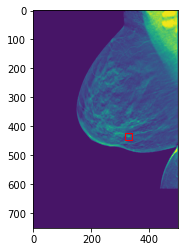

In [29]:
#print(outputs)
import matplotlib.patches as patches

index        = random.randint(0, len(valid_dataset)-1)
images, b, c = valid_dataset[index]

print(images.shape)
plt.imshow(images[0])
ax   = plt.gca()

print(all_target[index])
print(all_scores[index])

temp  = all_target[index]
index = 0
rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
ax.add_patch(rect)

temp  = b['boxes'].data.cpu().numpy()#all_target[index]
index = 0
rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='red', fill = False)
ax.add_patch(rect)


#rect = patches.Rectangle((0, 0), 500, 100, linewidth=2, edgecolor='cyan', fill = False)

plt.show()


In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images, targets, image_ids = next(iter(train_data_loader))
images  = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes  = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

In [ ]:
# [STAR] For plotting the images

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [15]:
loss_hist = Averager()
itr = 1
num_epochs = 200
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #print(len(images), len(targets), images[0].shape, len(targets[0]['boxes']))
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Iteration #50 loss: 1.7607202701618698
Iteration #100 loss: 1.7268396514227657
Iteration #150 loss: 1.7064545852167243
Iteration #200 loss: 2.0347349650472
Iteration #250 loss: 1.712778722073257
Iteration #300 loss: 1.5943888343150856
Iteration #350 loss: 1.5178248758969637
Iteration #400 loss: 1.5444363160208001
Iteration #450 loss: 1.5647550482854071
Iteration #500 loss: 1.5485437903163515
Iteration #550 loss: 1.9103887034181755
Iteration #600 loss: 1.491785500489904
Iteration #650 loss: 1.466433896319538
Epoch #0 loss: 1.7162335509320108
Iteration #700 loss: 1.7310519640009574
Iteration #750 loss: 1.4555127588148413
Iteration #800 loss: 1.4856642979590085
Iteration #850 loss: 2.133777053700693
Iteration #900 loss: 1.6277719320275719
Iteration #950 loss: 1.44726940291462
Iteration #1000 loss: 1.3971989617046594
Iteration #1050 loss: 1.3552668006526838
Iteration #1100 loss: 1.375852235221211
Iteration #1150 loss: 1.3284461516759858
Iteration #1200 loss: 1.3081550448389287
Iteration #1

KeyboardInterrupt: 

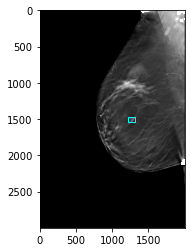

In [24]:
# [STAR] DBT Training Code

import matplotlib.patches as patches
import random

from torchvision import  transforms as T

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from PIL import Image

index = random.randint(0, len(td1)-1)
a, b, c = td1[index]
temp  = b['boxes'].data.cpu().numpy()
index = random.randint(0, len(temp)-1)

#print(temp)

im    = a.data.cpu().numpy()
plt.imshow(im[0].astype('float32'), cmap='gray')

ax   = plt.gca()


index = 0
rect = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
#rect = patches.Rectangle((temp[index][1], temp[index][0]), temp[index][3]-temp[index][1], temp[index][2]-temp[index][0], linewidth=1, edgecolor='cyan', fill = False)
ax.add_patch(rect)
#rect = patches.Rectangle((0, 0), 500, 100, linewidth=2, edgecolor='cyan', fill = False)


plt.show()

In [138]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = DBTDataset()
#valid_dataset = DBTDataset()


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

# valid_data_loader = DataLoader(
#     valid_dataset,
#     batch_size=8,
#     shuffle=False,
#     num_workers=4,
#     collate_fn=collate_fn
# )

In [143]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

num_classes = 2

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=0.5)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 20

In [145]:
num_epochs = 2000

loss_hist = Averager()
itr = 1
#train_dataset = td1
#model.train()
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for k in range(len(train_dataset)-1):
        images, targets, image_ids = train_dataset[k]
        #for images, targets, image_ids in train_data_loader:
        #print(images, targets)
        
        images  = [images]
        targets = [targets]
        #images  = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        
        loss_dict = model(images, targets)
        
        #losses = loss_dict['loss_rpn_box_reg'] + loss_dict['loss_objectness']
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(loss_dict)
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 

{'loss_classifier': tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.7729, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)}
Iteration #50 loss: nan
{'loss_classifier': tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.7726, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)}
Iteration #100 loss: nan
{'loss_classifier': tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.7703, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0031, device='cuda:0', grad

KeyboardInterrupt: 

In [121]:
print(targets)

[{'boxes': tensor([[  76., 1665.,  254., 1791.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([156]), 'area': tensor([22428.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]


In [107]:
model.eval()

images, targets, image_ids = train_dataset[k]
images  = [images]
targets = [targets]

loss_dict = model(images)
        

In [106]:
model.eval()
images  = [images]
#cpu_device = torch.device("cpu")
outputs = model(images)
#outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

AttributeError: 'list' object has no attribute 'shape'

In [110]:
print(loss_dict[0]['boxes'])

tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>)


In [101]:
print(images[0].shape)

torch.Size([1, 3000, 2000])


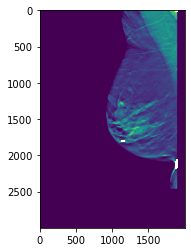

In [103]:
plt.imshow(images[0][0].cpu())